In [1]:
from google.colab import drive, files
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

drive.mount('/content/drive')

workspace_path = "/content/drive/MyDrive/GoruntuIsleme/real-vs-fake"

os.chdir(workspace_path)

Mounted at /content/drive


In [2]:
import os


# Klasör yapısını kontrol edin
required_dirs = ["train", "Validation", "test"]
sub_dirs = ["real", "fake"]

for dir_name in required_dirs:
    dir_path = os.path.join(workspace_path, dir_name)
    if not os.path.exists(dir_path):
        print(f"Klasör yok: {dir_path}")
    else:
        for sub_dir in sub_dirs:
            sub_dir_path = os.path.join(dir_path, sub_dir)
            if not os.path.exists(sub_dir_path):
                print(f"Alt klasör yok: {sub_dir_path}")

# test klasöründeki dosyaların kontrol edilmesi
test_dir = os.path.join(workspace_path, "test")
for sub_dir in sub_dirs:
    sub_dir_path = os.path.join(test_dir, sub_dir)
    if os.path.exists(sub_dir_path):
        print(f"Kontrol ediliyor: {sub_dir_path}")
        for file_name in os.listdir(sub_dir_path):
            if not file_name.endswith(('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')):
                print(f"Geçersiz dosya uzantısı: {file_name}")
            else:
                print(f"Geçerli dosya: {file_name}")

# Veri yükleyiciler
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Veri dönüşümleri
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Veri yükleyiciler
train_dataset = datasets.ImageFolder(root=os.path.join(workspace_path, "train"), transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)

validation_dataset = datasets.ImageFolder(root=os.path.join(workspace_path, "Validation"), transform=transform)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=16, shuffle=False)

test_dataset = datasets.ImageFolder(root=os.path.join(workspace_path, "test"), transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

print("Veri yükleyiciler başarıyla oluşturuldu.")


Kontrol ediliyor: /content/drive/MyDrive/GoruntuIsleme/real-vs-fake/test/real
Geçerli dosya: 159.jpg
Geçerli dosya: 146.jpg
Geçerli dosya: 109.jpg
Geçerli dosya: 115.jpg
Geçerli dosya: 133.jpg
Geçerli dosya: 106.jpg
Geçerli dosya: 113.jpg
Geçerli dosya: 162.jpg
Geçerli dosya: 102.jpg
Geçerli dosya: 152.jpg
Geçerli dosya: 129.jpg
Geçerli dosya: 164.jpg
Geçerli dosya: 111.jpg
Geçerli dosya: 12.jpg
Geçerli dosya: 108.jpg
Geçerli dosya: 131.jpg
Geçerli dosya: 140.jpg
Geçerli dosya: 143.jpg
Geçerli dosya: 151.jpg
Geçerli dosya: 166.jpg
Geçerli dosya: 144.jpg
Geçerli dosya: 141.jpg
Geçerli dosya: 136.jpg
Geçerli dosya: 14.jpg
Geçerli dosya: 122.jpg
Geçerli dosya: 105.jpg
Geçerli dosya: 17.jpg
Geçerli dosya: 124.jpg
Geçerli dosya: 142.jpg
Geçerli dosya: 117.jpg
Geçerli dosya: 160.jpg
Geçerli dosya: 137.jpg
Geçerli dosya: 170.jpg
Geçerli dosya: 11.jpg
Geçerli dosya: 103.jpg
Geçerli dosya: 127.jpg
Geçerli dosya: 161.jpg
Geçerli dosya: 150.jpg
Geçerli dosya: 125.jpg
Geçerli dosya: 130.jpg
Geçerl

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Modeli yükleme
model = models.shufflenet_v2_x1_0(pretrained=True)

# MobilNetV3'ten farklı olarak ShuffleNet'te sınıflandırma katmanı son konvolüsyon katmanıdır
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 sınıflı bir çıkış olacağı için son katmanın çıkışını 2 olarak değiştiriyoruz

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [ ]:
# Eğitim
num_epochs = 20
best_accuracy = 0.0
early_stopping_counter = 0

train_losses = []
val_accuracies = []
val_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    # Eğitim aşaması
    model.train()
    running_loss = 0.0
    correct_train = 0.0
    total_train = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Doğrulama aşaması
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in validation_loader:
             images, labels = images.to(device), labels.to(device)
             outputs = model(images)
             loss = criterion(outputs, labels)
             running_val_loss += loss.item() * images.size(0)
             _, predicted = torch.max(outputs, 1)
             total_val += labels.size(0)
             correct_val += (predicted == labels).sum().item()
    val_loss = running_val_loss / len(validation_loader.dataset)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping kontrolü
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= 5:
            print("Early stopping triggered.")
            break

Epoch 1/20, Train Loss: 0.6914, Train Accuracy: 0.5547, Validation Loss: 0.6902, Validation Accuracy: 0.5547
Epoch 2/20, Train Loss: 0.6894, Train Accuracy: 0.5556, Validation Loss: 0.6887, Validation Accuracy: 0.5547
Epoch 3/20, Train Loss: 0.6882, Train Accuracy: 0.5556, Validation Loss: 0.6879, Validation Accuracy: 0.5547
Epoch 4/20, Train Loss: 0.6876, Train Accuracy: 0.5556, Validation Loss: 0.6873, Validation Accuracy: 0.5547
Epoch 5/20, Train Loss: 0.6868, Train Accuracy: 0.5556, Validation Loss: 0.6870, Validation Accuracy: 0.5547
Epoch 6/20, Train Loss: 0.6864, Train Accuracy: 0.5556, Validation Loss: 0.6869, Validation Accuracy: 0.5547
Early stopping triggered.


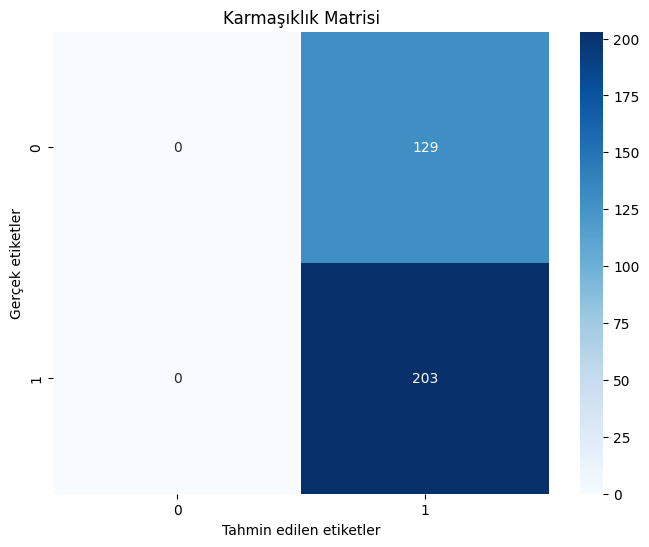

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Test
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)  # Çıktılardan en yüksek değere sahip sınıfı seç
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Confusion matrix ve görselleştirme
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Tahmin edilen etiketler')
plt.ylabel('Gerçek etiketler')
plt.title('Karmaşıklık Matrisi')
plt.show()


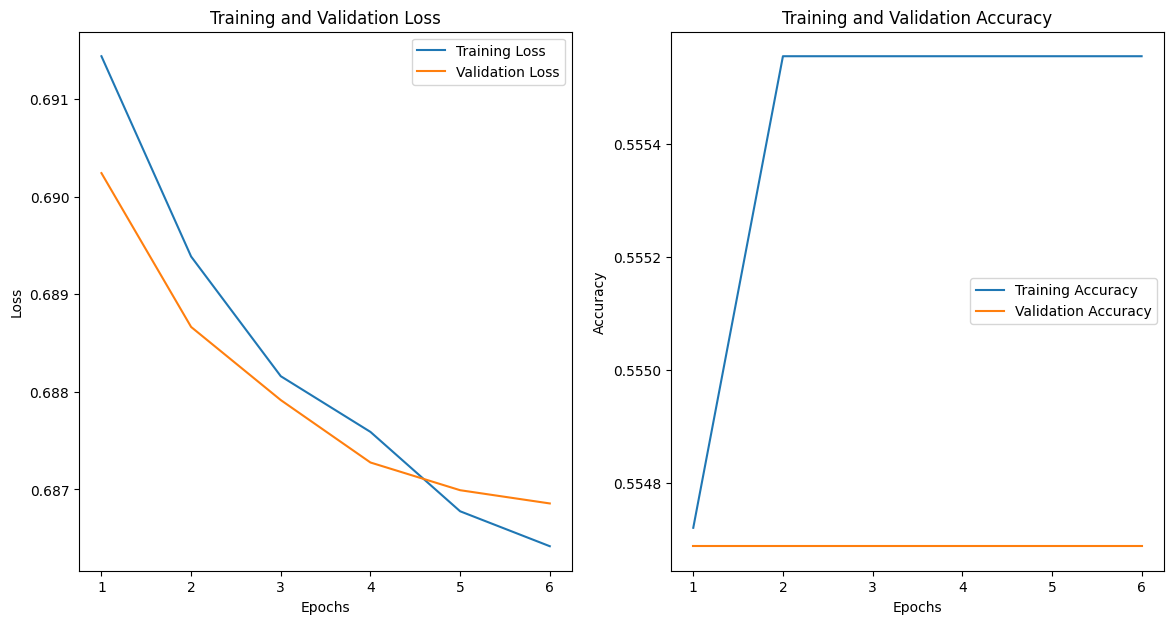

In [ ]:
# Grafik çizme
plt.figure(figsize=(14, 7))

# Eğitim ve Doğrulama Kayıpları Grafiği
plt.subplot(1, 2, 1)
plt.plot(range(1, min(num_epochs, len(train_losses))+1), train_losses, label='Training Loss')
plt.plot(range(1, min(num_epochs, len(val_losses))+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Eğitim ve Doğrulama Doğrulukları Grafiği
plt.subplot(1, 2, 2)
plt.plot(range(1, min(num_epochs, len(train_accuracies))+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, min(num_epochs, len(val_accuracies))+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

**otimizer ve lr değeri değiştirilid**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Modeli yükleme
model = models.shufflenet_v2_x1_0(pretrained=True)

# MobilNetV3'ten farklı olarak ShuffleNet'te sınıflandırma katmanı son konvolüsyon katmanıdır
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 sınıflı bir çıkış olacağı için son katmanın çıkışını 2 olarak değiştiriyoruz

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [ ]:
# Eğitim
num_epochs = 20
best_accuracy = 0.0
early_stopping_counter = 0

train_losses = []
val_accuracies = []
val_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    # Eğitim aşaması
    model.train()
    running_loss = 0.0
    correct_train = 0.0
    total_train = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Doğrulama aşaması
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in validation_loader:
             images, labels = images.to(device), labels.to(device)
             outputs = model(images)
             loss = criterion(outputs, labels)
             running_val_loss += loss.item() * images.size(0)
             _, predicted = torch.max(outputs, 1)
             total_val += labels.size(0)
             correct_val += (predicted == labels).sum().item()
    val_loss = running_val_loss / len(validation_loader.dataset)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping kontrolü
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= 5:
            print("Early stopping triggered.")
            break

Epoch 1/20, Train Loss: 0.6891, Train Accuracy: 0.5631, Validation Loss: 0.6851, Validation Accuracy: 0.5566
Epoch 2/20, Train Loss: 0.6685, Train Accuracy: 0.6232, Validation Loss: 0.6646, Validation Accuracy: 0.5957
Epoch 3/20, Train Loss: 0.6109, Train Accuracy: 0.7143, Validation Loss: 0.6577, Validation Accuracy: 0.6348
Epoch 4/20, Train Loss: 0.5387, Train Accuracy: 0.7694, Validation Loss: 0.6846, Validation Accuracy: 0.6387
Epoch 5/20, Train Loss: 0.4566, Train Accuracy: 0.8246, Validation Loss: 0.6776, Validation Accuracy: 0.6621
Epoch 6/20, Train Loss: 0.3666, Train Accuracy: 0.8847, Validation Loss: 0.6894, Validation Accuracy: 0.6758
Epoch 7/20, Train Loss: 0.2793, Train Accuracy: 0.9223, Validation Loss: 0.7311, Validation Accuracy: 0.6641
Epoch 8/20, Train Loss: 0.1983, Train Accuracy: 0.9524, Validation Loss: 0.8088, Validation Accuracy: 0.6797
Epoch 9/20, Train Loss: 0.1353, Train Accuracy: 0.9674, Validation Loss: 0.8471, Validation Accuracy: 0.6797
Epoch 10/20, Train 

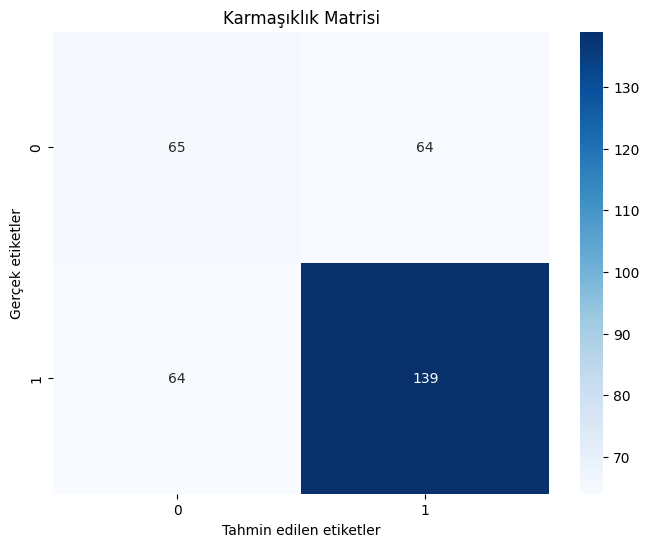

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Test
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)  # Çıktılardan en yüksek değere sahip sınıfı seç
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Confusion matrix ve görselleştirme
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Tahmin edilen etiketler')
plt.ylabel('Gerçek etiketler')
plt.title('Karmaşıklık Matrisi')
plt.show()


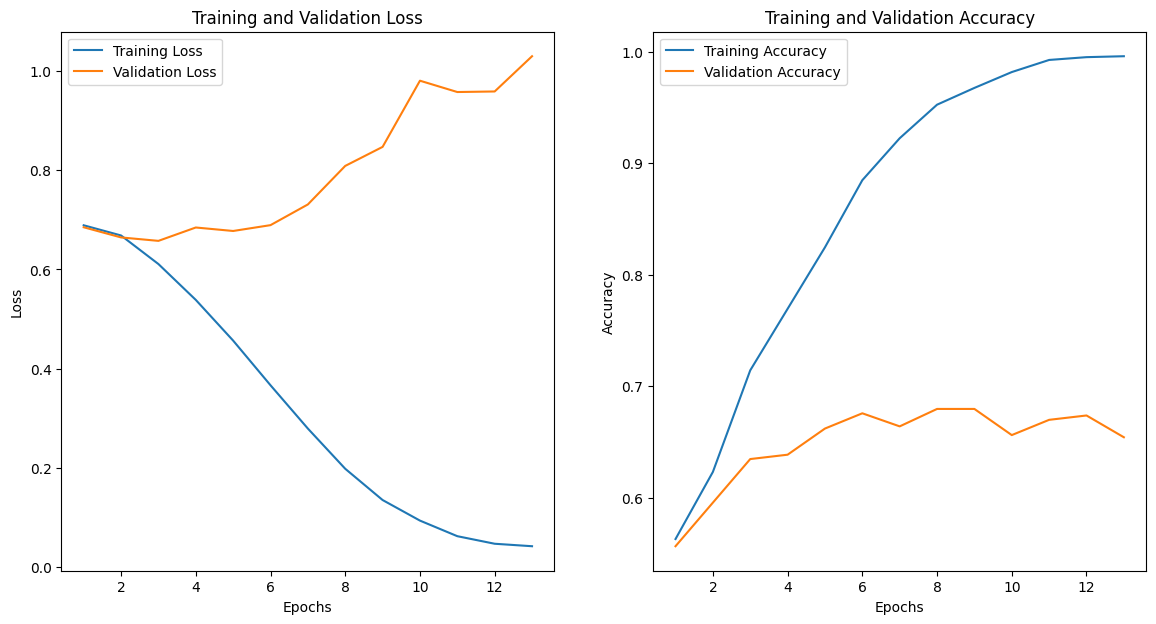

In [ ]:
# Grafik çizme
plt.figure(figsize=(14, 7))

# Eğitim ve Doğrulama Kayıpları Grafiği
plt.subplot(1, 2, 1)
plt.plot(range(1, min(num_epochs, len(train_losses))+1), train_losses, label='Training Loss')
plt.plot(range(1, min(num_epochs, len(val_losses))+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Eğitim ve Doğrulama Doğrulukları Grafiği
plt.subplot(1, 2, 2)
plt.plot(range(1, min(num_epochs, len(train_accuracies))+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, min(num_epochs, len(val_accuracies))+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [3]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout(0.5)

# Create an instance of the class
model = MyModel()

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Modeli yükleme
model = models.shufflenet_v2_x1_0(pretrained=True)

# MobilNetV3'ten farklı olarak ShuffleNet'te sınıflandırma katmanı son konvolüsyon katmanıdır
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 sınıflı bir çıkış olacağı için son katmanın çıkışını 2 olarak değiştiriyoruz

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 46.4MB/s]


In [5]:
# Eğitim
num_epochs = 25

train_losses = []
val_accuracies = []
val_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    # Eğitim aşaması
    model.train()
    running_loss = 0.0
    correct_train = 0.0
    total_train = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Doğrulama aşaması
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in validation_loader:
             images, labels = images.to(device), labels.to(device)
             outputs = model(images)
             loss = criterion(outputs, labels)
             running_val_loss += loss.item() * images.size(0)
             _, predicted = torch.max(outputs, 1)
             total_val += labels.size(0)
             correct_val += (predicted == labels).sum().item()
    val_loss = running_val_loss / len(validation_loader.dataset)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/25, Train Loss: 0.6903, Train Accuracy: 0.5347, Validation Loss: 0.6839, Validation Accuracy: 0.5781
Epoch 2/25, Train Loss: 0.6518, Train Accuracy: 0.6658, Validation Loss: 0.6514, Validation Accuracy: 0.6348
Epoch 3/25, Train Loss: 0.5648, Train Accuracy: 0.7335, Validation Loss: 0.6599, Validation Accuracy: 0.6348
Epoch 4/25, Train Loss: 0.4716, Train Accuracy: 0.7970, Validation Loss: 0.6823, Validation Accuracy: 0.6484
Epoch 5/25, Train Loss: 0.3629, Train Accuracy: 0.8680, Validation Loss: 0.7055, Validation Accuracy: 0.6621
Epoch 6/25, Train Loss: 0.2610, Train Accuracy: 0.9098, Validation Loss: 0.7162, Validation Accuracy: 0.6719
Epoch 7/25, Train Loss: 0.1672, Train Accuracy: 0.9549, Validation Loss: 0.8276, Validation Accuracy: 0.6855
Epoch 8/25, Train Loss: 0.1017, Train Accuracy: 0.9825, Validation Loss: 0.8472, Validation Accuracy: 0.6836
Epoch 9/25, Train Loss: 0.0611, Train Accuracy: 0.9900, Validation Loss: 0.8940, Validation Accuracy: 0.6699
Epoch 10/25, Train 

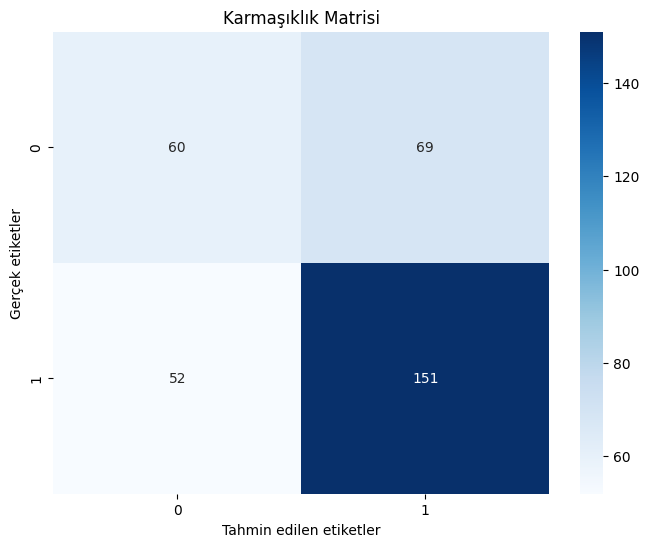

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Test
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)  # Çıktılardan en yüksek değere sahip sınıfı seç
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Confusion matrix ve görselleştirme
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Tahmin edilen etiketler')
plt.ylabel('Gerçek etiketler')
plt.title('Karmaşıklık Matrisi')
plt.show()


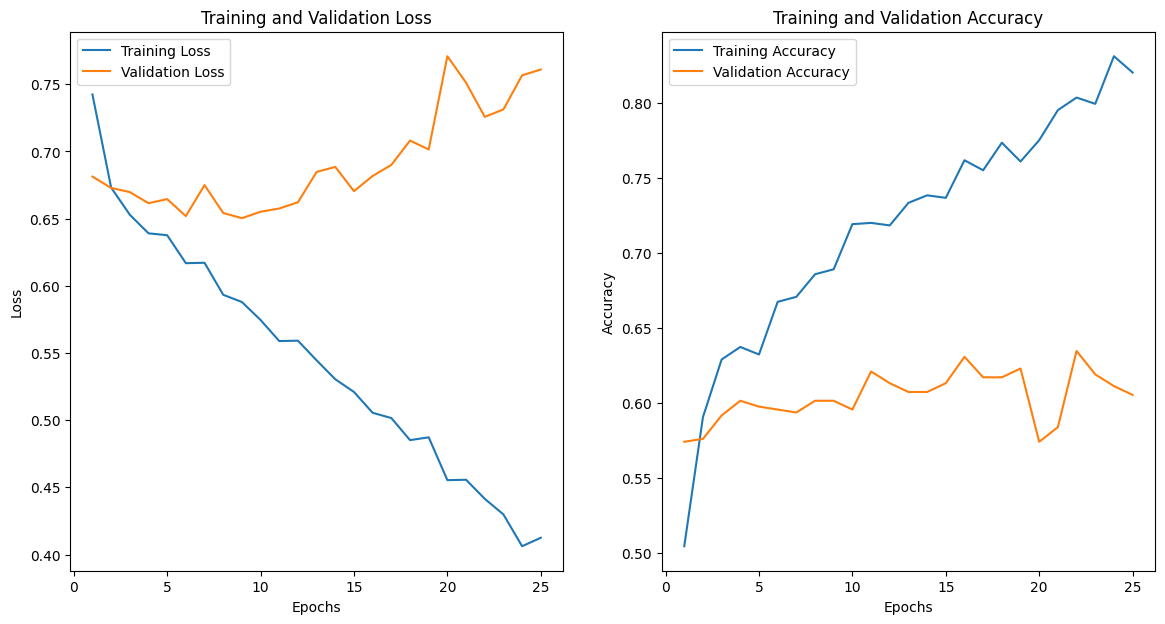

In [ ]:
# Grafik çizme
plt.figure(figsize=(14, 7))

# Eğitim ve Doğrulama Kayıpları Grafiği
plt.subplot(1, 2, 1)
plt.plot(range(1, min(num_epochs, len(train_losses))+1), train_losses, label='Training Loss')
plt.plot(range(1, min(num_epochs, len(val_losses))+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Eğitim ve Doğrulama Doğrulukları Grafiği
plt.subplot(1, 2, 2)
plt.plot(range(1, min(num_epochs, len(train_accuracies))+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, min(num_epochs, len(val_accuracies))+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

**dp eklendi**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Modeli yükleme
model = models.shufflenet_v2_x1_0(pretrained=True)

# MobilNetV3'ten farklı olarak ShuffleNet'te sınıflandırma katmanı son konvolüsyon katmanıdır
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 sınıflı bir çıkış olacağı için son katmanın çıkışını 2 olarak değiştiriyoruz
num_classes = 2
model.classifier[1] = nn.Sequential(
    nn.Dropout(p=0.5),  # Dropout katmanı ekleyelim
    nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
)
model.num_classes = num_classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Eğitim
num_epochs = 20

train_losses = []
val_accuracies = []
val_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    # Eğitim aşaması
    model.train()
    running_loss = 0.0
    correct_train = 0.0
    total_train = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Doğrulama aşaması
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in validation_loader:
             images, labels = images.to(device), labels.to(device)
             outputs = model(images)
             loss = criterion(outputs, labels)
             running_val_loss += loss.item() * images.size(0)
             _, predicted = torch.max(outputs, 1)
             total_val += labels.size(0)
             correct_val += (predicted == labels).sum().item()
    val_loss = running_val_loss / len(validation_loader.dataset)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/20, Train Loss: 0.7260, Train Accuracy: 0.5313, Validation Loss: 0.6945, Validation Accuracy: 0.5605
Epoch 2/20, Train Loss: 0.6716, Train Accuracy: 0.5881, Validation Loss: 0.6810, Validation Accuracy: 0.5781
Epoch 3/20, Train Loss: 0.6689, Train Accuracy: 0.5948, Validation Loss: 0.6746, Validation Accuracy: 0.5684
Epoch 4/20, Train Loss: 0.6357, Train Accuracy: 0.6358, Validation Loss: 0.6659, Validation Accuracy: 0.5879
Epoch 5/20, Train Loss: 0.6219, Train Accuracy: 0.6650, Validation Loss: 0.6684, Validation Accuracy: 0.6016
Epoch 6/20, Train Loss: 0.6187, Train Accuracy: 0.6633, Validation Loss: 0.6586, Validation Accuracy: 0.6016
Epoch 7/20, Train Loss: 0.6167, Train Accuracy: 0.6591, Validation Loss: 0.6528, Validation Accuracy: 0.6250
Epoch 8/20, Train Loss: 0.5824, Train Accuracy: 0.6892, Validation Loss: 0.6538, Validation Accuracy: 0.6270
Epoch 9/20, Train Loss: 0.5653, Train Accuracy: 0.7026, Validation Loss: 0.6597, Validation Accuracy: 0.6270
Epoch 10/20, Train 

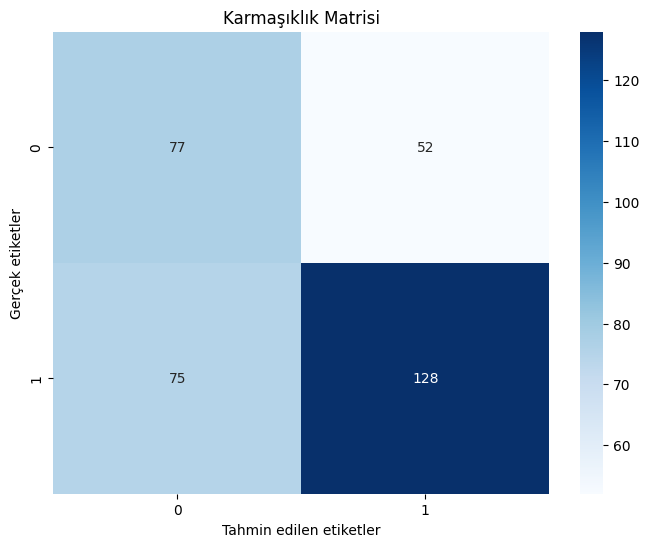

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Test
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)  # Çıktılardan en yüksek değere sahip sınıfı seç
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Confusion matrix ve görselleştirme
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Tahmin edilen etiketler')
plt.ylabel('Gerçek etiketler')
plt.title('Karmaşıklık Matrisi')
plt.show()


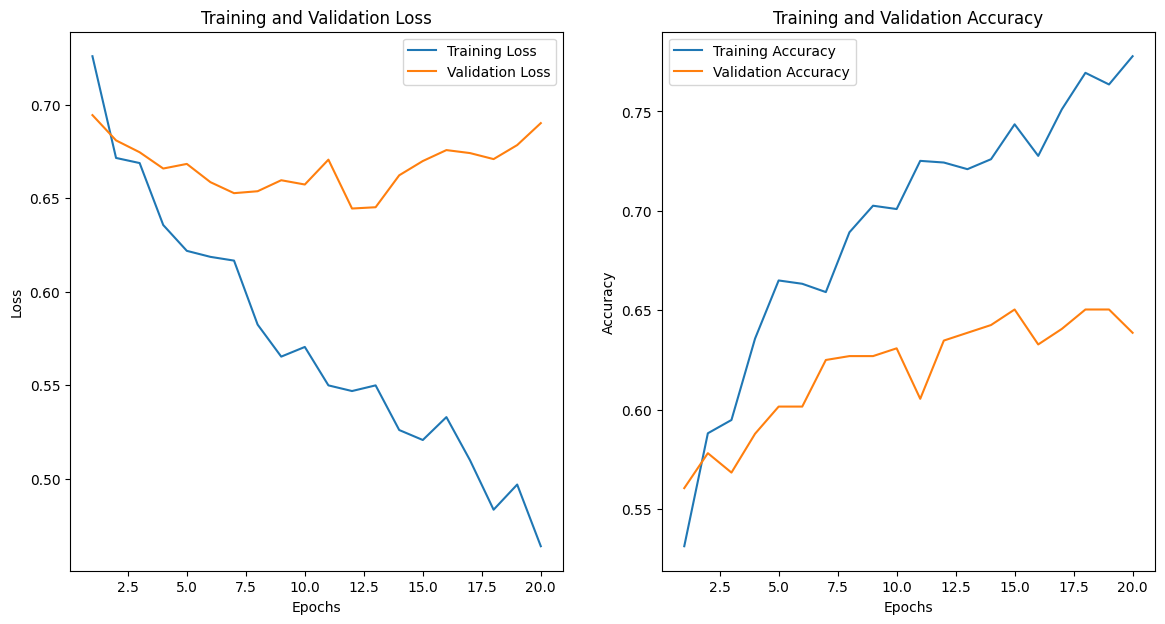

In [ ]:
# Grafik çizme
plt.figure(figsize=(14, 7))

# Eğitim ve Doğrulama Kayıpları Grafiği
plt.subplot(1, 2, 1)
plt.plot(range(1, min(num_epochs, len(train_losses))+1), train_losses, label='Training Loss')
plt.plot(range(1, min(num_epochs, len(val_losses))+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Eğitim ve Doğrulama Doğrulukları Grafiği
plt.subplot(1, 2, 2)
plt.plot(range(1, min(num_epochs, len(train_accuracies))+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, min(num_epochs, len(val_accuracies))+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

**batch_size küçültüldü**

In [ ]:
import os


# Klasör yapısını kontrol edin
required_dirs = ["train", "Validation", "test"]
sub_dirs = ["real", "fake"]

for dir_name in required_dirs:
    dir_path = os.path.join(workspace_path, dir_name)
    if not os.path.exists(dir_path):
        print(f"Klasör yok: {dir_path}")
    else:
        for sub_dir in sub_dirs:
            sub_dir_path = os.path.join(dir_path, sub_dir)
            if not os.path.exists(sub_dir_path):
                print(f"Alt klasör yok: {sub_dir_path}")

# test klasöründeki dosyaların kontrol edilmesi
test_dir = os.path.join(workspace_path, "test")
for sub_dir in sub_dirs:
    sub_dir_path = os.path.join(test_dir, sub_dir)
    if os.path.exists(sub_dir_path):
        print(f"Kontrol ediliyor: {sub_dir_path}")
        for file_name in os.listdir(sub_dir_path):
            if not file_name.endswith(('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')):
                print(f"Geçersiz dosya uzantısı: {file_name}")
            else:
                print(f"Geçerli dosya: {file_name}")

# Veri yükleyiciler
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Veri dönüşümleri
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Veri yükleyiciler
train_dataset = datasets.ImageFolder(root=os.path.join(workspace_path, "train"), transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)

validation_dataset = datasets.ImageFolder(root=os.path.join(workspace_path, "Validation"), transform=transform)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=8, shuffle=False)

test_dataset = datasets.ImageFolder(root=os.path.join(workspace_path, "test"), transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=False)

print("Veri yükleyiciler başarıyla oluşturuldu.")


Kontrol ediliyor: /content/drive/MyDrive/GoruntuIsleme/real-vs-fake/test/real
Geçerli dosya: 159.jpg
Geçerli dosya: 146.jpg
Geçerli dosya: 109.jpg
Geçerli dosya: 115.jpg
Geçerli dosya: 133.jpg
Geçerli dosya: 106.jpg
Geçerli dosya: 113.jpg
Geçerli dosya: 162.jpg
Geçerli dosya: 102.jpg
Geçerli dosya: 152.jpg
Geçerli dosya: 129.jpg
Geçerli dosya: 164.jpg
Geçerli dosya: 111.jpg
Geçerli dosya: 12.jpg
Geçerli dosya: 108.jpg
Geçerli dosya: 131.jpg
Geçerli dosya: 140.jpg
Geçerli dosya: 143.jpg
Geçerli dosya: 151.jpg
Geçerli dosya: 166.jpg
Geçerli dosya: 144.jpg
Geçerli dosya: 141.jpg
Geçerli dosya: 136.jpg
Geçerli dosya: 14.jpg
Geçerli dosya: 122.jpg
Geçerli dosya: 105.jpg
Geçerli dosya: 17.jpg
Geçerli dosya: 124.jpg
Geçerli dosya: 142.jpg
Geçerli dosya: 117.jpg
Geçerli dosya: 160.jpg
Geçerli dosya: 137.jpg
Geçerli dosya: 170.jpg
Geçerli dosya: 11.jpg
Geçerli dosya: 103.jpg
Geçerli dosya: 127.jpg
Geçerli dosya: 161.jpg
Geçerli dosya: 150.jpg
Geçerli dosya: 125.jpg
Geçerli dosya: 130.jpg
Geçerl

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Modeli yükleme
model = models.shufflenet_v2_x1_0(pretrained=True)

# MobilNetV3'ten farklı olarak ShuffleNet'te sınıflandırma katmanı son konvolüsyon katmanıdır
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 sınıflı bir çıkış olacağı için son katmanın çıkışını 2 olarak değiştiriyoruz
num_classes = 2
model.classifier[1] = nn.Sequential(
    nn.Dropout(p=0.5),  # Dropout katmanı ekleyelim
    nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
)
model.num_classes = num_classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**epoch sayısı arttı**

In [ ]:
# Eğitim
num_epochs = 30
best_accuracy = 0.0
early_stopping_counter = 0

train_losses = []
val_accuracies = []
val_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    # Eğitim aşaması
    model.train()
    running_loss = 0.0
    correct_train = 0.0
    total_train = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Doğrulama aşaması
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in validation_loader:
             images, labels = images.to(device), labels.to(device)
             outputs = model(images)
             loss = criterion(outputs, labels)
             running_val_loss += loss.item() * images.size(0)
             _, predicted = torch.max(outputs, 1)
             total_val += labels.size(0)
             correct_val += (predicted == labels).sum().item()
    val_loss = running_val_loss / len(validation_loader.dataset)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping kontrolü
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= 5:
            print("Early stopping triggered.")
            break

Epoch 1/30, Train Loss: 0.7689, Train Accuracy: 0.5096, Validation Loss: 0.7112, Validation Accuracy: 0.5254
Epoch 2/30, Train Loss: 0.7178, Train Accuracy: 0.5514, Validation Loss: 0.6862, Validation Accuracy: 0.5566
Epoch 3/30, Train Loss: 0.7089, Train Accuracy: 0.5622, Validation Loss: 0.6834, Validation Accuracy: 0.5488
Epoch 4/30, Train Loss: 0.6937, Train Accuracy: 0.5681, Validation Loss: 0.6759, Validation Accuracy: 0.5684
Epoch 5/30, Train Loss: 0.6864, Train Accuracy: 0.5731, Validation Loss: 0.6730, Validation Accuracy: 0.5742
Epoch 6/30, Train Loss: 0.6726, Train Accuracy: 0.5756, Validation Loss: 0.6761, Validation Accuracy: 0.5742
Epoch 7/30, Train Loss: 0.6678, Train Accuracy: 0.5739, Validation Loss: 0.6718, Validation Accuracy: 0.5820
Epoch 8/30, Train Loss: 0.6632, Train Accuracy: 0.5957, Validation Loss: 0.6668, Validation Accuracy: 0.5684
Epoch 9/30, Train Loss: 0.6572, Train Accuracy: 0.6090, Validation Loss: 0.6659, Validation Accuracy: 0.5742
Epoch 10/30, Train 

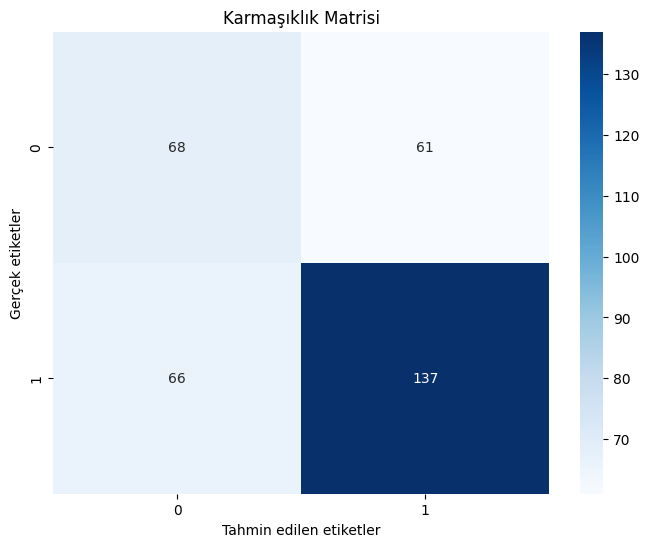

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Test
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)  # Çıktılardan en yüksek değere sahip sınıfı seç
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Confusion matrix ve görselleştirme
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Tahmin edilen etiketler')
plt.ylabel('Gerçek etiketler')
plt.title('Karmaşıklık Matrisi')
plt.show()


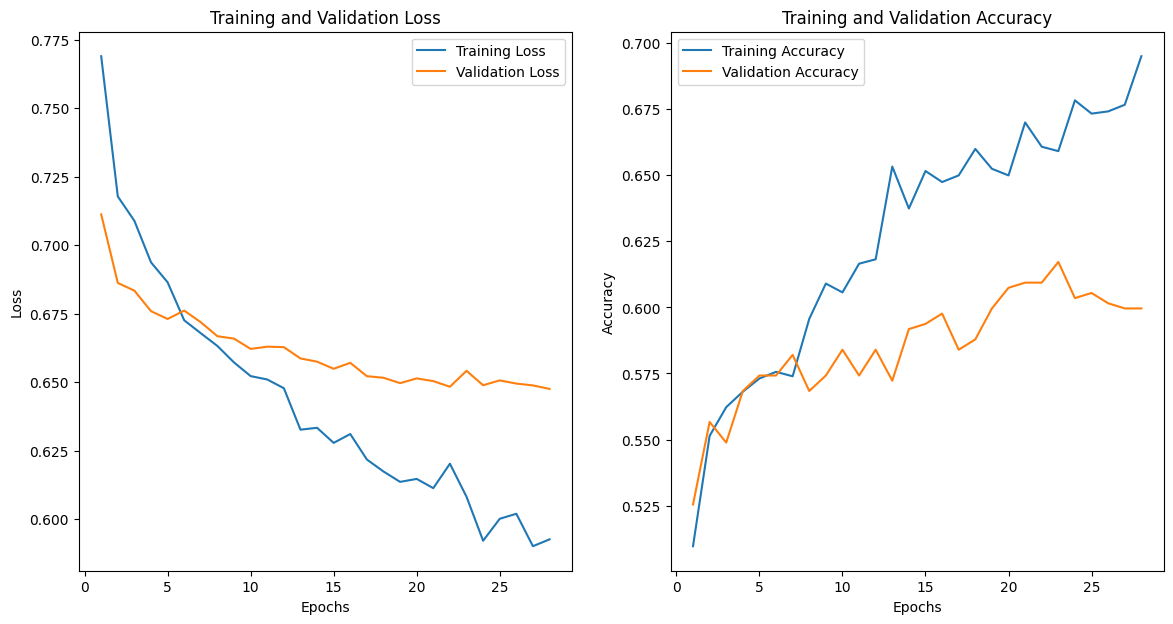

In [ ]:
# Grafik çizme
plt.figure(figsize=(14, 7))

# Eğitim ve Doğrulama Kayıpları Grafiği
plt.subplot(1, 2, 1)
plt.plot(range(1, min(num_epochs, len(train_losses))+1), train_losses, label='Training Loss')
plt.plot(range(1, min(num_epochs, len(val_losses))+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Eğitim ve Doğrulama Doğrulukları Grafiği
plt.subplot(1, 2, 2)
plt.plot(range(1, min(num_epochs, len(train_accuracies))+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, min(num_epochs, len(val_accuracies))+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

**batch_siz=128**

In [ ]:
import os


# Klasör yapısını kontrol edin
required_dirs = ["train", "Validation", "test"]
sub_dirs = ["real", "fake"]

for dir_name in required_dirs:
    dir_path = os.path.join(workspace_path, dir_name)
    if not os.path.exists(dir_path):
        print(f"Klasör yok: {dir_path}")
    else:
        for sub_dir in sub_dirs:
            sub_dir_path = os.path.join(dir_path, sub_dir)
            if not os.path.exists(sub_dir_path):
                print(f"Alt klasör yok: {sub_dir_path}")

# test klasöründeki dosyaların kontrol edilmesi
test_dir = os.path.join(workspace_path, "test")
for sub_dir in sub_dirs:
    sub_dir_path = os.path.join(test_dir, sub_dir)
    if os.path.exists(sub_dir_path):
        print(f"Kontrol ediliyor: {sub_dir_path}")
        for file_name in os.listdir(sub_dir_path):
            if not file_name.endswith(('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')):
                print(f"Geçersiz dosya uzantısı: {file_name}")
            else:
                print(f"Geçerli dosya: {file_name}")

# Veri yükleyiciler
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Veri dönüşümleri
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Veri yükleyiciler
train_dataset = datasets.ImageFolder(root=os.path.join(workspace_path, "train"), transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

validation_dataset = datasets.ImageFolder(root=os.path.join(workspace_path, "Validation"), transform=transform)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=128, shuffle=False)

test_dataset = datasets.ImageFolder(root=os.path.join(workspace_path, "test"), transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

print("Veri yükleyiciler başarıyla oluşturuldu.")


Kontrol ediliyor: /content/drive/MyDrive/GoruntuIsleme/real-vs-fake/test/real
Geçerli dosya: 159.jpg
Geçerli dosya: 146.jpg
Geçerli dosya: 109.jpg
Geçerli dosya: 115.jpg
Geçerli dosya: 133.jpg
Geçerli dosya: 106.jpg
Geçerli dosya: 113.jpg
Geçerli dosya: 162.jpg
Geçerli dosya: 102.jpg
Geçerli dosya: 152.jpg
Geçerli dosya: 129.jpg
Geçerli dosya: 164.jpg
Geçerli dosya: 111.jpg
Geçerli dosya: 12.jpg
Geçerli dosya: 108.jpg
Geçerli dosya: 131.jpg
Geçerli dosya: 140.jpg
Geçerli dosya: 143.jpg
Geçerli dosya: 151.jpg
Geçerli dosya: 166.jpg
Geçerli dosya: 144.jpg
Geçerli dosya: 141.jpg
Geçerli dosya: 136.jpg
Geçerli dosya: 14.jpg
Geçerli dosya: 122.jpg
Geçerli dosya: 105.jpg
Geçerli dosya: 17.jpg
Geçerli dosya: 124.jpg
Geçerli dosya: 142.jpg
Geçerli dosya: 117.jpg
Geçerli dosya: 160.jpg
Geçerli dosya: 137.jpg
Geçerli dosya: 170.jpg
Geçerli dosya: 11.jpg
Geçerli dosya: 103.jpg
Geçerli dosya: 127.jpg
Geçerli dosya: 161.jpg
Geçerli dosya: 150.jpg
Geçerli dosya: 125.jpg
Geçerli dosya: 130.jpg
Geçerl

**learning_rate =0.001 dp**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Modeli yükleme
model = models.shufflenet_v2_x1_0(pretrained=True)

# MobilNetV3'ten farklı olarak ShuffleNet'te sınıflandırma katmanı son konvolüsyon katmanıdır
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 sınıflı bir çıkış olacağı için son katmanın çıkışını 2 olarak değiştiriyoruz
num_classes = 2
model.classifier[1] = nn.Sequential(
    nn.Dropout(p=0.5),  # Dropout katmanı ekleyelim
    nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
)
model.num_classes = num_classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Eğitim
num_epochs = 30
best_accuracy = 0.0
early_stopping_counter = 0

train_losses = []
val_accuracies = []
val_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    # Eğitim aşaması
    model.train()
    running_loss = 0.0
    correct_train = 0.0
    total_train = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Doğrulama aşaması
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in validation_loader:
             images, labels = images.to(device), labels.to(device)
             outputs = model(images)
             loss = criterion(outputs, labels)
             running_val_loss += loss.item() * images.size(0)
             _, predicted = torch.max(outputs, 1)
             total_val += labels.size(0)
             correct_val += (predicted == labels).sum().item()
    val_loss = running_val_loss / len(validation_loader.dataset)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping kontrolü
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= 5:
            print("Early stopping triggered.")
            break

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/30, Train Loss: 0.7623, Train Accuracy: 0.5146, Validation Loss: 0.7069, Validation Accuracy: 0.5566
Epoch 2/30, Train Loss: 0.7291, Train Accuracy: 0.5472, Validation Loss: 0.6991, Validation Accuracy: 0.5508
Epoch 3/30, Train Loss: 0.7167, Train Accuracy: 0.5581, Validation Loss: 0.6935, Validation Accuracy: 0.5469
Epoch 4/30, Train Loss: 0.7112, Train Accuracy: 0.5439, Validation Loss: 0.6892, Validation Accuracy: 0.5527
Epoch 5/30, Train Loss: 0.7002, Train Accuracy: 0.5455, Validation Loss: 0.6856, Validation Accuracy: 0.5566
Epoch 6/30, Train Loss: 0.6887, Train Accuracy: 0.5614, Validation Loss: 0.6822, Validation Accuracy: 0.5684
Epoch 7/30, Train Loss: 0.6762, Train Accuracy: 0.5931, Validation Loss: 0.6798, Validation Accuracy: 0.5684
Epoch 8/30, Train Loss: 0.6778, Train Accuracy: 0.5990, Validation Loss: 0.6774, Validation Accuracy: 0.5781
Epoch 9/30, Train Loss: 0.6806, Train Accuracy: 0.5823, Validation Loss: 0.6753, Validation Accuracy: 0.5801
Epoch 10/30, Train 

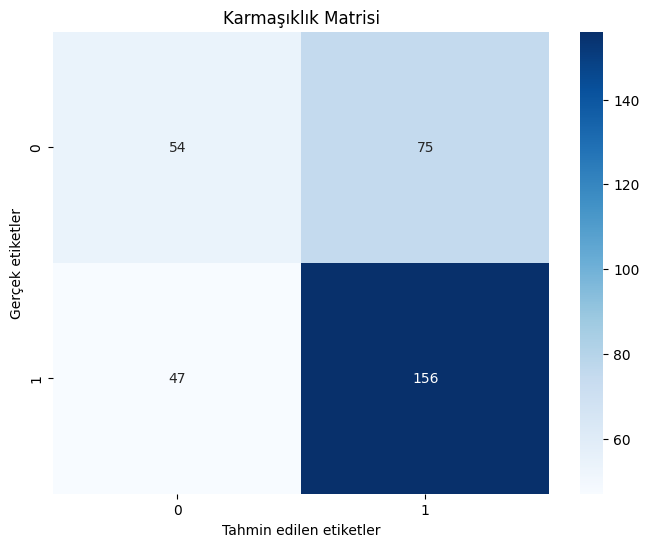

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Test
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)  # Çıktılardan en yüksek değere sahip sınıfı seç
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Confusion matrix ve görselleştirme
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Tahmin edilen etiketler')
plt.ylabel('Gerçek etiketler')
plt.title('Karmaşıklık Matrisi')
plt.show()


In [ ]:
# Grafik çizme
plt.figure(figsize=(14, 7))

# Eğitim ve Doğrulama Kayıpları Grafiği
plt.subplot(1, 2, 1)
plt.plot(range(1, min(num_epochs, len(train_losses))+1), train_losses, label='Training Loss')
plt.plot(range(1, min(num_epochs, len(val_losses))+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Eğitim ve Doğrulama Doğrulukları Grafiği
plt.subplot(1, 2, 2)
plt.plot(range(1, min(num_epochs, len(train_accuracies))+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, min(num_epochs, len(val_accuracies))+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()